<a href="https://colab.research.google.com/github/KidCon/BOTGAR/blob/main/HuggingFace_Diffusers_Pokemon_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train a Diffusion Model for Pokemon from scratch


- Train diffusion model from scratch using: https://huggingface.co/datasets/huggan/few-shot-pokemon
- Log progress using Weights and Biases


In [1]:
%pip install -qq -U diffusers datasets transformers wandb

In [2]:
import wandb
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch
from PIL import Image
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [5]:
run = wandb.init(project='stable-diffusion-pokemon')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rdp. Use `wandb login --relogin` to force relogin


## Setup the dataset

In [6]:
dataset = load_dataset("huggan/few-shot-pokemon", split="train")

In [7]:
sample_im = dataset['image'][3]

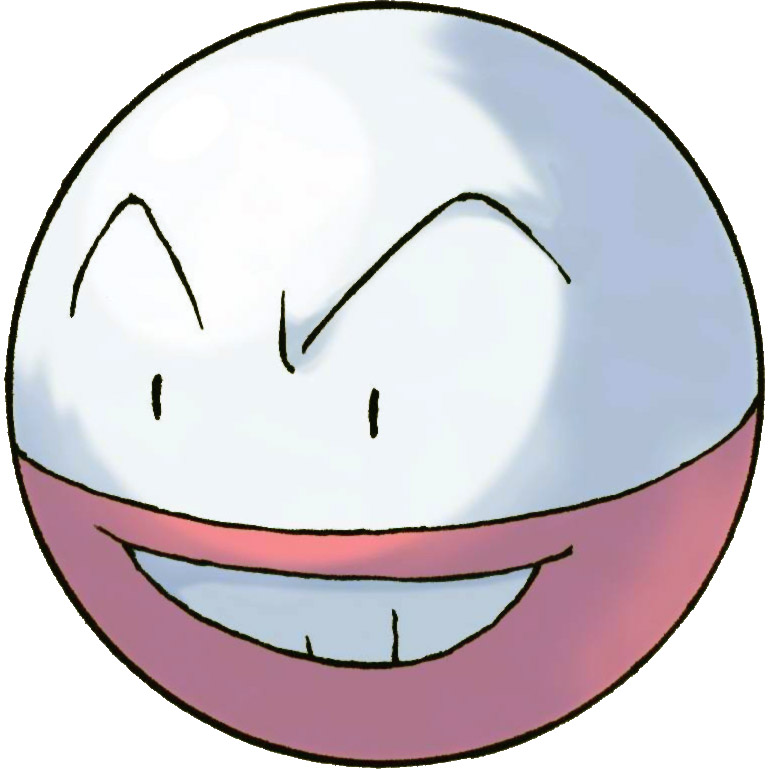

In [8]:
sample_im

In [9]:
image_size=64

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ]
)

In [10]:
def transform(input_images):
  images = [preprocess(image.convert("RGB")) for image in input_images["image"]]
  return {"images": images}

In [11]:
dataset.set_transform(transform)

batch_size=32

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

sample_batch shape: torch.Size([32, 3, 64, 64])


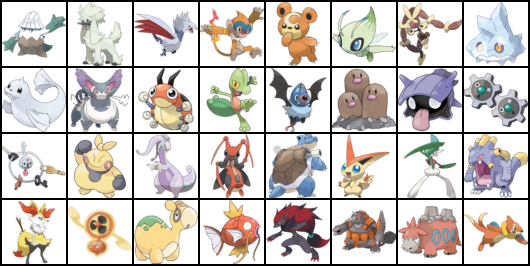

In [12]:
sample_batch = next(iter(train_dataloader))["images"].to(device)
print("sample_batch shape:", sample_batch.shape)
show_images(sample_batch)

In [13]:
# sample_batch

## Define the Scheduler

In [14]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noisy sample_batch shape torch.Size([32, 3, 64, 64])


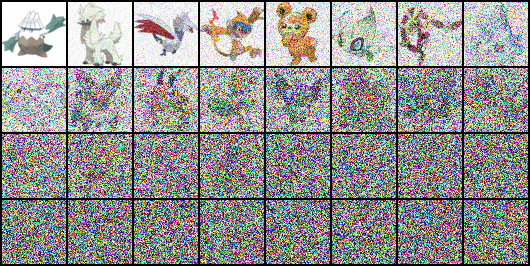

In [15]:
timesteps = torch.linspace(0, 999, 32).long().to(device)
noise = torch.randn_like(sample_batch)
noisy_sample_batch = noise_scheduler.add_noise(sample_batch, noise, timesteps)
print("Noisy sample_batch shape", noisy_sample_batch.shape)
show_images(noisy_sample_batch)


## Step 4: Define the Model

In [16]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
    
)

model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Con

In [17]:
with torch.no_grad():
  model_prediction = model(noisy_sample_batch, timesteps).sample
model_prediction.shape

torch.Size([32, 3, 64, 64])

## Step 5: Create a Training Loop

In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []


In [19]:
print(len(train_dataloader))

27


In [20]:
for epoch in range(10):
  for step, batch in enumerate(train_dataloader):

    clean_images = batch["images"].to(device)
    o = show_images(clean_images)

    # print(clean_images.shape)
    # print(clean_images.device)


    noise = torch.randn(clean_images.shape).to(clean_images.device)
    # print(noise.shape)


    # sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size, ), device=clean_images.device).long()
    # print(timesteps)

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
    # print(f'noisy_images.shape: {noisy_images.shape}')
    n = show_images(noisy_images)

    # Get the model prediction
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
    # print(f'noise_pred.shape: {noise_pred.shape}')
    noise_pred_im = show_images(noise_pred)

    # Calculate the loss
    loss = F.mse_loss(noise_pred, noise)
    # print(f'loss.shape: {loss.shape}')
    # print(f'loss: {loss}')
    loss.backward(loss)
    losses.append(loss.item())

    # Update the model parameters with the optimizer
    optimizer.step()
    optimizer.zero_grad()


  if (epoch + 1) % 5 == 0:
    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch: {epoch+1}, loss: {loss_last_epoch}")




Epoch: 5, loss: 0.07567739141760049
Epoch: 10, loss: 0.06116523179743025


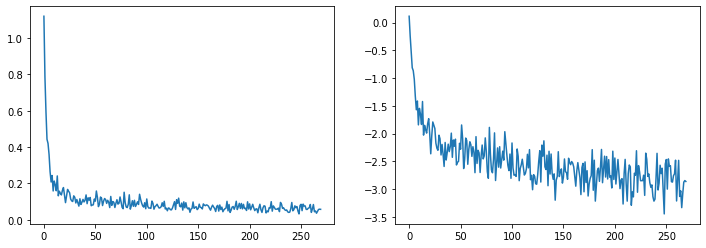

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

In [22]:
# Option 1 - Creating a pipeline

from diffusers import DDPMPipeline
image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()


  0%|          | 0/1000 [00:00<?, ?it/s]

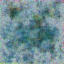

In [23]:
pipeline_output.images[0]

In [38]:
# Option 2 - sampling

# Random starting point (8 random images):
sample = torch.randn(8, 3, image_size, image_size).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

  # Get model pred
  with torch.no_grad():
    residual = model(sample, t).sample


  # Update sample with step
  sample = noise_scheduler.step(residual, t, sample).prev_sample



In [23]:
run = wandb.init(project='playground')

for i in range(2):


  wandb.log({'round': i})
  sample = torch.randn(8, 3, image_size, image_size).to(device)

  for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
      residual = model(sample, t).sample


    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

  images = show_images(sample)
  wandb.log({'image': wandb.Image(images)})


run.finish()

round,▁█
round,1


In [29]:
sample.shape

torch.Size([8, 3, 32, 32])

In [34]:
im = Image.fromarray(sample)

AttributeError: ignored

In [30]:
t = wandb.Image(sample)

In [33]:
t

AttributeError: ignored

In [39]:
o = show_images(sample)

In [40]:
type(o)

PIL.Image.Image

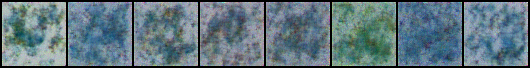

In [41]:
o

In [26]:
image_pipe.save_pretrained("my_pipeline")
!ls my_pipeline/

model_index.json  scheduler  unet


In [ ]:
# Add artifcat to wandb
artifact = wandb.Artifact('model', type='model')
artifact.add_dir('my_pipeline') # Adds multiple files to artifact
run.log_artifact(artifact) # Creates `animals:v0`


wandb: Adding directory to artifact (./my_pipeline)... Done. 0.1s


In [ ]:
wandb.finish()

## Full wandb Script


In [1]:
%pip install -qq -U diffusers datasets transformers wandb

In [2]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [3]:
import wandb
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from tqdm.auto import tqdm
from diffusers import DDPMPipeline
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch
from PIL import Image
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt


In [4]:
image_size = 64
batch_size = 32
grad_accumulation_steps = 0
num_epochs = 5000
dataset_name = "huggan/few-shot-pokemon"
device = 'cuda'
model_save_name = 'pokemon-diffusion-model'
wandb_project = 'stable-diffusion-pokemon'
log_samples_every = 250
save_model_every = 2500

wandb_config = {
    "wandb_project": wandb_project,
    "image_size": image_size,
    "log_samples_every": log_samples_every,
    "save_model_every": save_model_every,
    "dataset_name": dataset_name,
    "num_epochs": num_epochs,
    "image_size": image_size,
    "batch_size": batch_size

}

In [ ]:
run = wandb.init(project=wandb_project, config=wandb_config)

#################### Prepare the dataset
dataset = load_dataset(dataset_name, split="train")

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

def transform(input_images):
  images = [preprocess(image.convert("RGB")) for image in input_images["image"]]
  return {"images": images}

dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)



#################### Define the scheduler


# I think DDPM is bad, DDIM is better but I don't exactly know why
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



# Create a model
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
    
)


model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
losses = []


for epoch in range(num_epochs):
  for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

    clean_images = batch["images"].to(device)
    
    noise = torch.randn(clean_images.shape).to(clean_images.device)
  
    # sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size, ), device=clean_images.device).long()
  

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)


    # Get the model prediction
    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

    # Calculate the loss
    loss = F.mse_loss(noise_pred, noise)
    wandb.log({'loss': loss.item()})


    loss.backward(loss)
    losses.append(loss.item())

    # Update the model parameters with the optimizer
    optimizer.step()
    optimizer.zero_grad()

    # if (step+1) % log_samples_every == 0:
    #   x = torch.randn(8, 3, image_size, image_size).to(device) # Batch of 8
    #     for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    #       model_input = noise_scheduler.scale_model_input(x, t)
    #       with torch.no_grad():
    #         noise_pred = image_pipe.unet()

    

    

    # if (step+1) % save_model_every == 0:
    #   image_pipe.save_pretrained(model_save_name+f'step_{step+1}')
  loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
  wandb.log({'loss_last_epoch': loss_last_epoch})

  if (epoch + 1) % 5 == 0:
    loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch: {epoch+1}, loss: {loss_last_epoch}")

    # Create image samples
    print(f'generating images for epoch {epoch}')
    sample = torch.randn(8, 3, image_size, image_size).to(device)  

    for i, t in enumerate(noise_scheduler.timesteps):
      # Get model pred
      with torch.no_grad():
        residual = model(sample, t).sample


      # Update sample with step
      sample = noise_scheduler.step(residual, t, sample).prev_sample
    wandb.log({'Sample generations': wandb.Image(show_images(sample))})


  if (epoch + 1) % 100 == 0:
    saved_name = f"pipeline_{epoch}"
    image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
    image_pipe.save_pretrained(saved_name)
    artifact = wandb.Artifact('model', type='model')
    artifact.add_dir(saved_name) # Adds multiple files to artifact
    run.log_artifact(artifact) # Creates `animals:v0`





run.finish()

wandb: Currently logged in as: rdp. Use `wandb login --relogin` to force relogin


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 5, loss: 0.0768607634085196
generating images for epoch 4


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]